In [49]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from scipy.stats import norm

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace
#from statsmodels.stats.proportion import proportion_ztest

# Step 1: Acquire Data From CSV File

In [29]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [30]:
beach_complete.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0
2009-06-09,NaN,37.0,368.0,63.0,11.0,20.0,16.0,11.0,12.0,18.0,34.0


In [31]:
beach_clean = beach_complete.dropna()

In [32]:
beach_clean.apply(pd.to_numeric);

In [33]:
#fig, ax = plt.subplots(6, 2, figsize=(20,40))
#cols = beach_clean.columns
#for i in range(6):
#    for j in range(2):
#        if j == 1 and i == 5:
#            break
#        elif j == 0:
#            ax[i][j].hist(np.log(beach_clean[cols[i]].values), bins=50, histtype='stepfilled')
#            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
            #set_trace()
#        else:
#            ax[i][j].hist(np.log(beach_clean[cols[i+6]]).values, bins=50, histtype='stepfilled')
#            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])

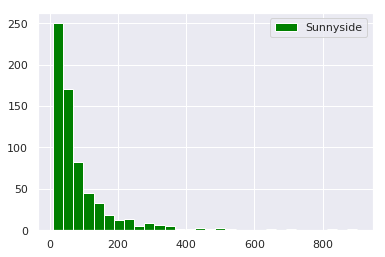

In [58]:
plt.hist(beach_clean['Sunnyside-2'], bins=30, histtype='bar', color='green', label = 'Sunnyside')
plt.legend()
plt.show();

In [55]:
sample_size = 150
mu = beach_clean['Sunnyside-2'].mean()
sigma = beach_clean['Sunnyside-2'].std()
#rand_norm = np.random.normal(mu, sigma, 150)
sunnyside = beach_clean['Sunnyside-2'].values
normed = norm.rvs(mu, sigma, sample_size)
#plt.plot(sunnyside, normed, 'r-')
#sunnyside_sample = np.random.choice(sunnyside, sample_size)

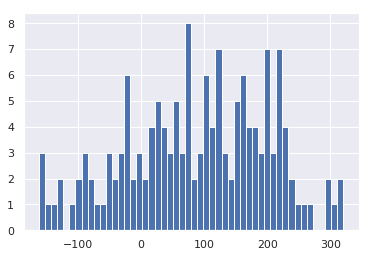

In [57]:
plt.hist(normed, bins=50, histtype='bar')
plt.show();

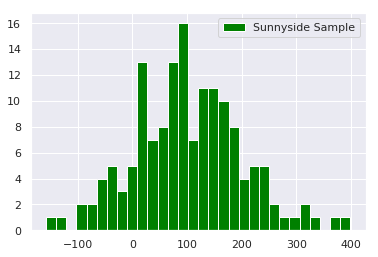

In [47]:
plt.hist(rand_norm, bins=30, histtype='bar', color='green', label = 'Sunnyside Sample')
plt.legend()
plt.show();

# Step 2: Remove unwanted seasonality & check stationarity

# Step 4: ACF and PACF plots

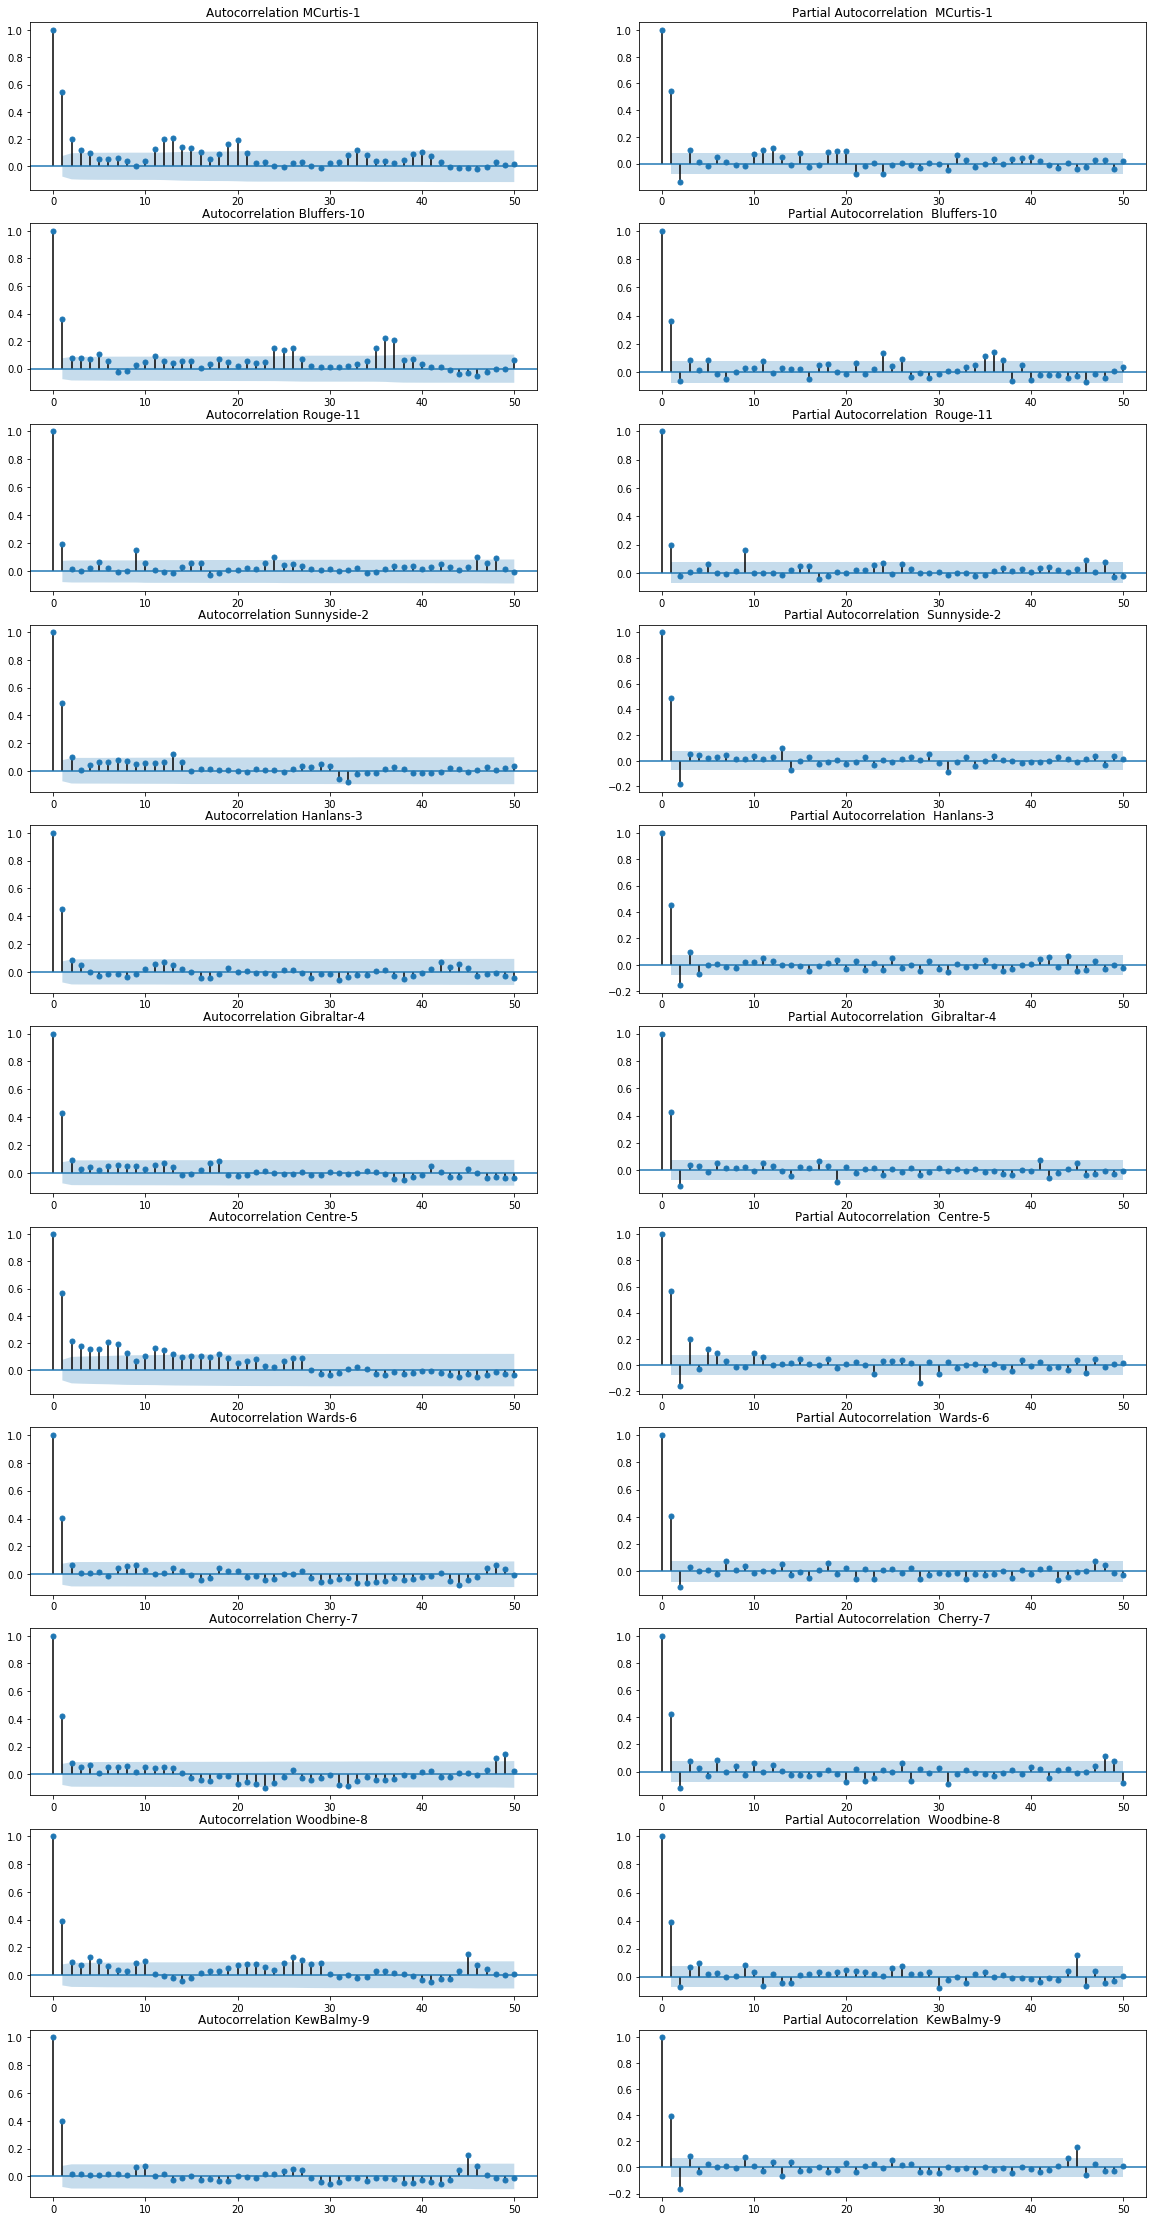

In [15]:
def plot_acf_pacf(list_tuples):
    fig, ax = plt.subplots(11, 2, figsize=(20,40))
    for i in range(len(list_tuples)):
        for j in range(len(list_tuples[i])-1):
            str_title_acf = "Autocorrelation " + list_tuples[i][1]
            str_title_pacf = "Partial Autocorrelation  " + list_tuples[i][1]
            plot_acf(list_tuples[i][0], lags=50, title=str_title_acf, ax=ax[i][j])
            plot_pacf(list_tuples[i][0], lags=50, title=str_title_pacf, ax=ax[i][j+1])
    
    plt.show();

plot_acf_pacf(list_tuples)

For all 11 beaches, it seems that with a lag=6 there will be very little partial correlation. So we assume lag=6 for both our AR and MA parameters for now.

# Step 5: Train and Test ARIMA model 

In [16]:
#Get 70% train, 30% test datasets for all beaches data
def get_train_test(tuples):
    train_data, test_data = [], []
    train_titles, test_titles = [], []
    #err_check_ctr = 0
    for tup in tuples:
        training_size = int(tup[0].values.size * 0.7)
        training_set = tup[0][:training_size]
        testing_set = tup[0][training_size:tup[0].values.size]
        training_title = 'Training ' + tup[1]
        testing_title = 'Testing ' + tup[1]
        
        #check if there are any null values in train/test datasets
        #err_check_ctr = 1
        #if err_check_ctr == 1:
        #    assert training_set.notnull().values.any(), 'Null Values Found in Training Dataset!'
        #    assert testing_set.notnull().values.any(), 'Null Values Found in Testing Dataset!'
        #    err_check_ctr = 0
        
        train_data.append(training_set)
        test_data.append(testing_set)
        train_titles.append(training_title)
        test_titles.append(testing_title)
    
    return (pd.DataFrame(train_data).transpose().dropna(), pd.DataFrame(test_data).transpose().dropna())

train_test_tuple = get_train_test(list_tuples)    

In [17]:
train_test_tuple[0].head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2009-06-01,27,12,39,28,11,18,24,63,51,10,10
2009-06-02,10,14,52,16,10,18,22,18,19,10,10
2009-06-03,22,11,14,10,10,11,14,10,10,10,10
2009-06-04,26,10,11,10,10,11,11,10,10,10,10
2009-06-05,35,10,31,11,10,10,10,12,10,10,10
2009-06-06,133,13,29,18,12,10,12,16,10,12,10
2009-06-07,604,16,20,97,37,28,41,47,10,12,11
2009-06-08,405,17,99,142,31,33,43,39,10,10,12
2009-06-10,170,25,155,26,11,18,21,11,12,18,31


In [18]:
train_test_tuple[1].head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2016-06-10,10,16,10,11,10,18,11,14,11,12,12
2016-06-11,49,27,38,13,10,16,22,11,11,12,33
2016-06-12,112,29,38,34,10,16,20,11,23,12,33
2016-06-13,23,11,10,29,13,21,29,41,59,10,10
2016-06-14,11,11,10,12,14,22,53,59,31,10,11
2016-06-15,11,11,21,13,13,11,22,22,20,10,12
2016-06-16,14,14,38,13,14,25,25,18,19,20,23
2016-06-17,14,23,18,16,12,23,21,11,11,20,25
2016-06-18,10,19,13,22,10,11,10,11,12,10,12


In [19]:
#Instantiate the ARIMA model with train data and create a model just to predict
#the N+1 entry using the trained data
def single_model_arima(train_data, train_titles):
    arr = np.zeros((1, 4))
    arima_model_fits = []
    residues = []
    train_titles_arr = np.array([train_titles])
    for beach in train_data:
        amodel = ARIMA(endog=beach.values, order=(6,1,1)) #initialize the ARIMA model with training data
        amodel_fit = amodel.fit(disp=1,maxiter=500) #fit the ARIMA model to the training data
        residues.append(pd.DataFrame(amodel_fit.resid))
        p, err, conf = amodel_fit.forecast() #ARIMA model forecast
        
        params = np.append(p,[err[0],conf[0][0],conf[0][1]]) #Get the parameters (p, err, conf) into an array
        arima_model_fits.append(amodel_fit) #Get all the fit models so we can get their summaries later on
        #set_trace()
        arr = np.append(arr,[params], axis=0) #Append params array to main array
    
    arr = np.delete(arr, (0), axis=0)
    arr = np.concatenate((arr, train_titles_arr.T), axis=1)
    
    return (pd.DataFrame(arr[:,:4], index=arr[:,4].T, columns=['N+1 Prediction','Std Error','CI Low','CI High']),
            residues)

train_data = [train_test_tuple[0][col] for col in train_test_tuple[0]]
train_titles = [col for col in train_test_tuple[0]]
train_results, train_residues = single_model_arima(train_data, train_titles)

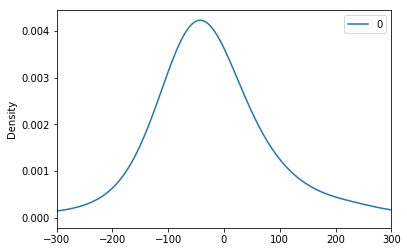

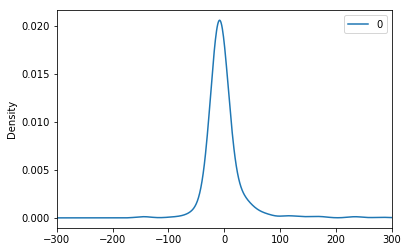

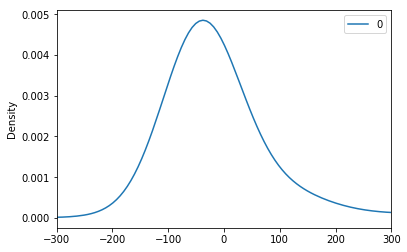

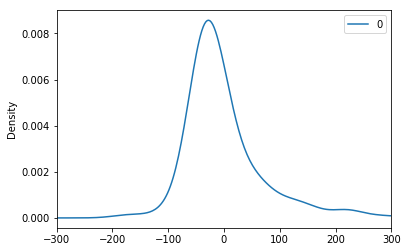

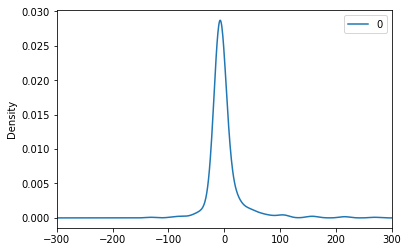

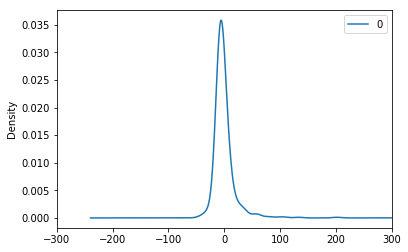

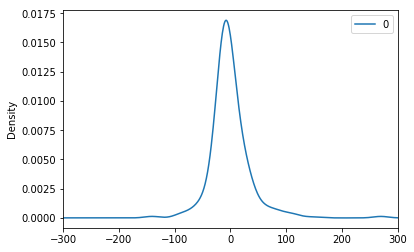

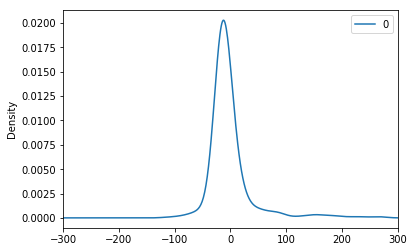

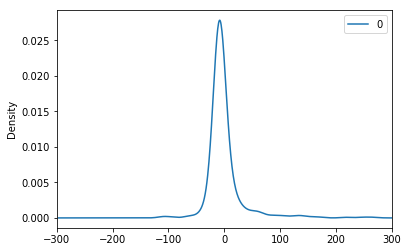

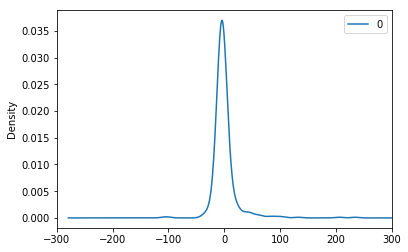

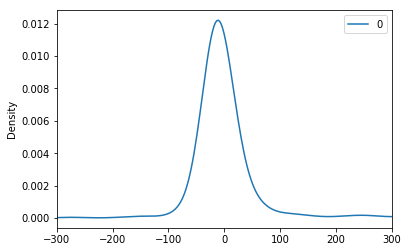

In [20]:
for res in train_residues:
    res.plot(kind='kde', xlim=(-300,300))

In [21]:
#Change all values in training results to float64
train_results = train_results.applymap(float)

In [22]:
train_results.head()

,N+1 Prediction,Std Error,CI Low,CI High
MCurtis-1,47.367677,181.390084,-308.150356,402.885709
Bluffers-10,17.642182,44.563223,-69.700129,104.984494
Rouge-11,27.250980,201.921347,-368.507588,423.009549
Sunnyside-2,60.283176,88.351065,-112.881729,233.448081
Hanlans-3,19.961804,32.175032,-43.100101,83.023709


In [23]:
#Check percentage differences between predictions and actual test values
abs_diff = np.abs(train_results['N+1 Prediction'] - train_test_tuple[1].iloc[0])
abs_diff

MCurtis-1      37.367677
Bluffers-10     1.642182
Rouge-11       17.250980
Sunnyside-2    49.283176
Hanlans-3       9.961804
Gibraltar-4     5.156963
Centre-5       20.227022
Wards-6        16.340203
Cherry-7       12.965013
Woodbine-8      0.417853
KewBalmy-9      8.289153
dtype: float64

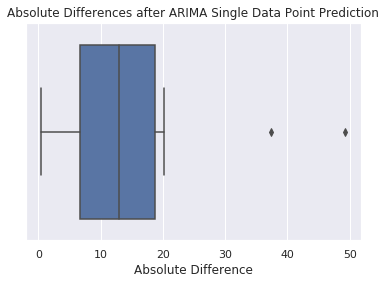

In [24]:
sns.set(style='darkgrid')
ax = sns.boxplot(x=abs_diff)
ax.set(xlabel='Absolute Difference', title='Absolute Differences after ARIMA Single Data Point Prediction');

The above percentage errors varies from -34% (lowest) to 328% (highest). These values represents the difference between predicted vs actual e.Coli count. For smaller differences, it can be said that the model fits well. However for larger differences, more predictions are needed based on the arima model.

In following section, more predictions are done for all beaches except for MCurtis, Centre, Woodbine, and Kewbalmy as the percentage error is small for these four. 

In [25]:
#Create more predictions using arima model TODO

#def multi_model_arima(train_test_tuple, train_titles):
#    arr = np.zeros((1, train_test_tuple[1]['MCurtis-1'].size))
    #print(arr)
#    train_titles_arr = np.array([train_titles])
#    for col in train_test_tuple[0]:
#        pred=[]
#        hist=list(train_test_tuple[0][col].values)

#        for i in range(train_test_tuple[1][col].size):
            #step 0: Initialize the ARIMA model
#            arima_model = ARIMA(endog=hist, order=(1,1,1))
            #step 1: Fit the arima model
            #set_trace()
#            arima_fit = arima_model.fit(disp=1, maxiter=100)
            #step 2: Forecast with the arima model
#            p = arima_fit.forecast()[0][0]
            #step 3: Add predicted value (p) to prediction list
            #set_trace()
#            pred.append(p)
            #step 4: Then add the current value to the history
#            hist.append(train_test_tuple[1][col].values[i])
            #step 5: Append the predicted results to the return array
        
        #set_trace()
#        pred_array = np.array(pred)
#        arr = np.append(arr, [pred], axis=0)
    
#    arr = np.delete(arr, (0), axis=0)
#    print(arr)
        #arr = np.concatenate((arr, pred), axis=0)
        #print(arr)
        #break
               
#train_data = [train_test_tuple[0][col] for col in train_test_tuple[0]]
#train_titles = [col for col in train_test_tuple[0]]
#predictions = [pred1, pred10, pred11, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9]
#print(train_test_tuple[1]['MCurtis-1'].size)
#multi_model_arima(train_test_tuple, train_titles)

In [ ]:
pred_sunnyside=[]
hist_sunnyside=list(train_test_tuple[0]['Sunnyside-2'].values)

for i in range(train_test_tuple[1]['Sunnyside-2'].size):
    arima_model_sunnyside = ARIMA(endog=hist_sunnyside, order=(6,1,1))
    arima_fit_sunnyside = arima_model_sunnyside.fit()
    p_sunnyside = arima_fit_sunnyside.forecast()[0][0]
    pred_sunnyside.append(p_sunnyside)
    hist_sunnyside.append(train_test_tuple[1]['Sunnyside-2'].values[i]) #pass 611

Graph the predictions and the actual values of the test data below.

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_sunnyside, 'r-')
plt.plot(train_test_tuple[1]['Sunnyside-2'].values, '--')
plt.title('Sunnyside Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

Eyeballing the graphs above, the ARIMA model seems to have done a good job at predicting the last 30% of the Sunnyside beach e.Coli count (2016-2018) based on the first 70% (2009-2016). This needs to be verified by comparing the rmse values with all the other beaches.

In [ ]:
mean_square_err_sunnyside = mean_squared_error(pred_sunnyside, train_test_tuple[1]['Sunnyside-2'].values)
print("Mean square error Sunnyside:", mean_square_err_sunnyside)

In [ ]:
rmse_sunnyside = np.sqrt(mean_square_err_sunnyside)

In [ ]:
print("RMSE Sunnyside:", rmse_sunnyside)

In [ ]:
rmses = np.array([rmse_mcurtis, rmse_sunnyside, rmse_hanlans, rmse_gibraltar, 
         rmse_centre, rmse_wards, rmse_cherry, rmse_woodbine, rmse_kewbalmy, rmse_bluffers, rmse_rouge])

rmse_df = pd.DataFrame(rmses, columns=['RMSE'])
rmse_df

sns.set(style='darkgrid')
ax = sns.boxplot(x=rmse_df['RMSE'])
ax.set(xlabel='RMSE', title='RMSE values after ARIMA Expanded Prediction');

# Step 6: ARIMA Model Test Results 

In [ ]:
arima_fit_sunnyside.summary()

The RMSE values closer to 0 indicates better fit. 

From above RMSE values, it is clear that ARIMA predictions were better for following beaches: Gibraltar, Centre, and Cherry. 

For Sunnyside, MCurtis and Kewbalmy, the ARIMA predictions are not reliable and hence other models should be used for better predictions. 

ARIMA did not perform so well for beaches Wards, Woodbine, and Rouge as well.

For all beaches, the ARIMA model with parameters (p,d,q) = (6,1,1) did not predict well on sudden spikes in e.Coli counts. This could possibly be because of the sudden changes that these spikes bring compared to the base values seen at the bottom of the above graphs. This will be explored in future with more fine-tuned ARIMA models. 